# Lesson 2: Flowers102 Dataset Exploration

## Overview
Explore the Flowers102 dataset (102 flower categories, 8,189 images) which will be used throughout all subsequent lessons.

### Learning Objectives
- Load and understand the Flowers102 dataset structure
- Visualize sample images and analyze class distribution
- Set up data preprocessing pipeline for training
- Create optimized DataLoaders for efficient training

### Dataset Quick Facts
- **Total Images**: 8,189 high-quality RGB photographs
- **Classes**: 102 different flower species
- **Splits**: Pre-defined train/validation/test sets
- **Resolution**: Variable sizes (typically 300-500 pixels)
- **Origin**: Oxford Visual Geometry Group (VGG)

## Step 1: Environment Setup and Library Imports

### Why This Step Matters
Setting up the environment correctly is crucial for:
- **Reproducibility**: Ensuring consistent results across different runs
- **Performance**: Optimizing visualization and computation settings
- **Debugging**: Clean output without unnecessary warnings

### Key Libraries Explained
- **numpy**: Fundamental numerical computing (array operations, mathematical functions)
- **matplotlib**: Data visualization and plotting (displaying images, creating charts)
- **torch**: Core PyTorch library (tensors, automatic differentiation)
- **torchvision**: Computer vision utilities (datasets, transforms, pre-trained models)
- **DataLoader**: Efficient batch processing and parallel data loading
- **tqdm**: Progress bars for long-running operations
- **Counter**: Efficient counting for statistical analysis

### Configuration Settings
We configure matplotlib for high-quality visualizations suitable for both notebook display and publication.

In [1]:
# Core numerical and visualization libraries
import numpy as np
import matplotlib.pyplot as plt

# PyTorch ecosystem for deep learning
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Utility libraries
from tqdm import tqdm  # Progress bars
from collections import Counter  # Efficient counting
import warnings
warnings.filterwarnings('ignore')  # Clean output

# Configure matplotlib for high-quality plots
plt.rcParams['figure.dpi'] = 100  # Display resolution
plt.rcParams['font.size'] = 10    # Readable font size

print("✅ Libraries imported successfully!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"🖼️ Torchvision version: {torchvision.__version__}")

✅ Libraries imported successfully!
📦 PyTorch version: 2.2.2
🖼️ Torchvision version: 0.17.2


## Step 2: Device Detection and Initial Data Loading

### Device Selection Strategy
Modern deep learning benefits greatly from GPU acceleration. Our device detection follows this priority:

1. **CUDA GPU** (NVIDIA): Fastest option for large-scale training
   - Parallel processing with thousands of cores
   - Optimized for matrix operations and neural networks
   - Industry standard for deep learning

2. **MPS (Apple Silicon)**: Apple's Metal Performance Shaders
   - Optimized for M1/M2 chips
   - Unified memory architecture
   - Good performance for development and small-scale training

3. **CPU**: Universal fallback
   - Works on any system
   - Slower but sufficient for learning and small datasets

### Data Loading Philosophy
We start with **basic transforms** to explore the raw dataset, then create more sophisticated preprocessing later. This two-stage approach:
- Allows us to understand the original data characteristics
- Prevents preprocessing artifacts from hiding data quality issues
- Makes debugging easier by isolating transformation effects

### Transform Pipeline Explanation
- **Resize(224, 224)**: Standardizes all images to 224×224 pixels
  - Why 224? Standard input size for many pre-trained models
  - Ensures consistent batch dimensions
  - Balances detail preservation with computational efficiency
- **ToTensor()**: Converts PIL Image to PyTorch tensor
  - Changes data type from uint8 (0-255) to float32 (0.0-1.0)
  - Rearranges dimensions from (H,W,C) to (C,H,W)
  - Enables GPU processing and automatic differentiation

In [2]:
# Device detection with fallback hierarchy
print("🔍 Detecting optimal compute device...")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using NVIDIA GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Using Apple Silicon GPU (MPS)")
    print("   Optimized for M1/M2 chips")
else:
    device = torch.device("cpu")
    print("💻 Using CPU (consider GPU for faster training)")

# Define basic transforms for initial exploration
print("\n🔧 Setting up basic data transformations...")
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standardize dimensions
    transforms.ToTensor()           # Convert to tensor [0,1]
])

print("   ✓ Resize: 224×224 pixels (standard CNN input)")
print("   ✓ ToTensor: PIL → PyTorch tensor conversion")

# Load Flowers102 dataset with automatic download
print("\n📥 Loading Flowers102 dataset...")
print("⏰ First run will download ~500MB - please be patient")

# Load all three splits
trainset = torchvision.datasets.Flowers102(
    root='./data', split='train', download=True, transform=basic_transform)
validset = torchvision.datasets.Flowers102(
    root='./data', split='val', download=True, transform=basic_transform)
testset = torchvision.datasets.Flowers102(
    root='./data', split='test', download=True, transform=basic_transform)

# Display dataset statistics
print("\n📊 Dataset Statistics:")
print(f"   🏋️ Training samples: {len(trainset):,}")
print(f"   🔍 Validation samples: {len(validset):,}")
print(f"   📝 Test samples: {len(testset):,}")
print(f"   📈 Total samples: {len(trainset) + len(validset) + len(testset):,}")
print(f"   🏷️ Number of classes: 102")
print(f"   📊 Avg samples per class: {(len(trainset) + len(validset) + len(testset)) / 102:.1f}")

🔍 Detecting optimal compute device...
🍎 Using Apple Silicon GPU (MPS)
   Optimized for M1/M2 chips

🔧 Setting up basic data transformations...
   ✓ Resize: 224×224 pixels (standard CNN input)
   ✓ ToTensor: PIL → PyTorch tensor conversion

📥 Loading Flowers102 dataset...
⏰ First run will download ~500MB - please be patient

📊 Dataset Statistics:
   🏋️ Training samples: 1,020
   🔍 Validation samples: 1,020
   📝 Test samples: 6,149
   📈 Total samples: 8,189
   🏷️ Number of classes: 102
   📊 Avg samples per class: 80.3


## Step 3: Data Visualization and Statistical Analysis

### Why Visualization Matters
Before training any model, we must understand our data through visualization:

**Visual Inspection Benefits:**
- **Quality Assessment**: Spot corrupted, blurry, or mislabeled images
- **Variety Understanding**: See the diversity within and across classes
- **Preprocessing Validation**: Ensure transforms work as expected
- **Bias Detection**: Identify potential dataset biases (lighting, angles, etc.)

### Statistical Analysis Importance
Class distribution analysis reveals:
- **Imbalanced Classes**: Some classes may have many more samples than others
- **Training Challenges**: Imbalanced data can lead to biased models
- **Evaluation Strategy**: Need appropriate metrics for imbalanced datasets
- **Augmentation Needs**: Underrepresented classes may need more augmentation

### Technical Implementation Details

**Image Display Process:**
1. **Random Sampling**: `np.random.choice()` ensures unbiased selection
2. **Tensor Conversion**: `.permute(1, 2, 0)` changes (C,H,W) → (H,W,C) for matplotlib
3. **Grid Layout**: Organized 3×4 grid for efficient space usage
4. **Metadata Display**: Class labels help connect visual features to categories

**Distribution Analysis Process:**
1. **Label Extraction**: Iterate through dataset to collect all class labels
2. **Counting**: Use `Counter` for efficient frequency counting
3. **Statistics**: Calculate min, max, average samples per class
4. **Comparison**: Analyze differences between train/val/test splits

🖼️ Displaying random samples from training set...


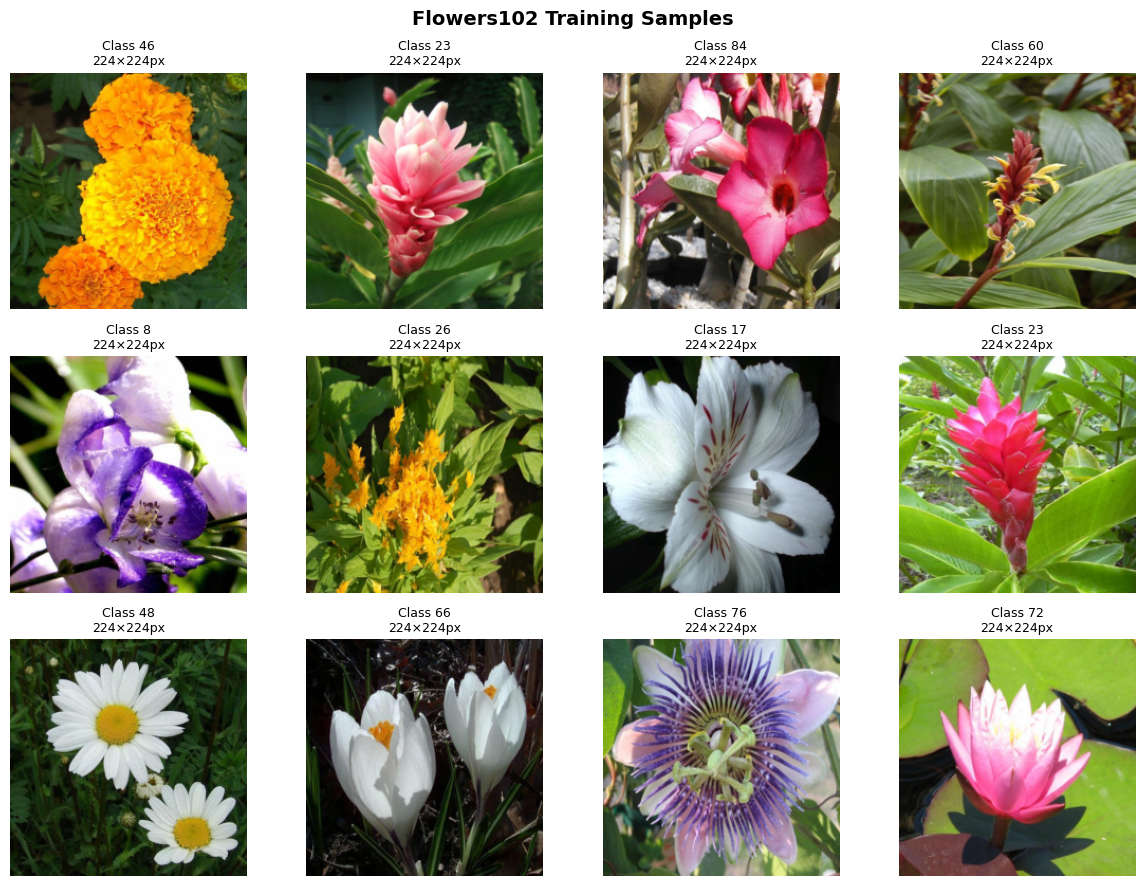


🔍 Comprehensive Distribution Analysis:

📊 Analyzing Training Set Distribution...
   📈 Total samples: 1,020
   🏷️ Unique classes: 102
   ⚖️ Avg per class: 10.0
   📉 Min per class: 10 samples
   📊 Max per class: 10 samples
   ⚠️ Imbalance ratio: 1.0:1
   ✅ Well-balanced dataset

📊 Analyzing Validation Set Distribution...
   📈 Total samples: 1,020
   🏷️ Unique classes: 102
   ⚖️ Avg per class: 10.0
   📉 Min per class: 10 samples
   📊 Max per class: 10 samples
   ⚠️ Imbalance ratio: 1.0:1
   ✅ Well-balanced dataset

📊 Analyzing Test Set Distribution...
   📈 Total samples: 6,149
   🏷️ Unique classes: 102
   ⚖️ Avg per class: 60.3
   📉 Min per class: 20 samples
   📊 Max per class: 238 samples
   ⚠️ Imbalance ratio: 11.9:1
   🔶 Moderate class imbalance detected

📋 Split Comparison Summary:
   Train/Val/Test ratio: 1020:1020:6149
   Percentage split: 12.5% / 12.5% / 75.1%


In [3]:
# Enhanced function to display sample images with detailed info
def show_samples(dataset, num_samples=12, title="Sample Images"):
    """
    Display a grid of sample images with enhanced information
    
    Args:
        dataset: PyTorch dataset object
        num_samples: Number of images to display (default: 12)
        title: Title for the plot
    """
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Random sampling without replacement for diversity
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Convert PyTorch tensor (C,H,W) to matplotlib format (H,W,C)
        img_np = image.permute(1, 2, 0).numpy()
        
        # Calculate grid position
        row, col = i // 4, i % 4
        
        # Display image with metadata
        axes[row, col].imshow(img_np)
        axes[row, col].set_title(
            f'Class {label}\n{img_np.shape[0]}×{img_np.shape[1]}px', 
            fontsize=9
        )
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display representative samples
print("🖼️ Displaying random samples from training set...")
show_samples(trainset, title="Flowers102 Training Samples")

# Enhanced function for statistical analysis
def analyze_distribution(dataset, split_name):
    """
    Comprehensive analysis of class distribution
    
    Args:
        dataset: PyTorch dataset object
        split_name: Name of the data split for reporting
    
    Returns:
        Counter object with class counts
    """
    print(f"\n📊 Analyzing {split_name} Set Distribution...")
    
    # Efficient label collection
    labels = [dataset[i][1] for i in range(len(dataset))]
    label_counts = Counter(labels)
    
    # Calculate comprehensive statistics
    total_samples = len(labels)
    num_classes = len(label_counts)
    avg_per_class = total_samples / num_classes
    min_samples = min(label_counts.values())
    max_samples = max(label_counts.values())
    
    # Imbalance analysis
    imbalance_ratio = max_samples / min_samples
    
    print(f"   📈 Total samples: {total_samples:,}")
    print(f"   🏷️ Unique classes: {num_classes}")
    print(f"   ⚖️ Avg per class: {avg_per_class:.1f}")
    print(f"   📉 Min per class: {min_samples} samples")
    print(f"   📊 Max per class: {max_samples} samples")
    print(f"   ⚠️ Imbalance ratio: {imbalance_ratio:.1f}:1")
    
    # Interpretation
    if imbalance_ratio > 3:
        print(f"   🔶 Moderate class imbalance detected")
    elif imbalance_ratio > 10:
        print(f"   🔴 Significant class imbalance - consider resampling")
    else:
        print(f"   ✅ Well-balanced dataset")
    
    return label_counts

# Analyze all data splits
print("\n🔍 Comprehensive Distribution Analysis:")
print("=" * 50)
train_dist = analyze_distribution(trainset, "Training")
val_dist = analyze_distribution(validset, "Validation")
test_dist = analyze_distribution(testset, "Test")

# Summary comparison
print("\n📋 Split Comparison Summary:")
print(f"   Train/Val/Test ratio: {len(trainset)}:{len(validset)}:{len(testset)}")
print(f"   Percentage split: {len(trainset)/sum([len(trainset), len(validset), len(testset)])*100:.1f}% / {len(validset)/sum([len(trainset), len(validset), len(testset)])*100:.1f}% / {len(testset)/sum([len(trainset), len(validset), len(testset)])*100:.1f}%")

## Step 4: Advanced Preprocessing Pipeline and DataLoader Setup

### Data Augmentation Strategy

**Why Augmentation is Critical:**
- **Increases Effective Dataset Size**: Transforms create new variations of existing images
- **Improves Generalization**: Model learns to handle variations in real-world data
- **Reduces Overfitting**: Prevents memorization of specific image characteristics
- **Handles Data Scarcity**: Particularly important for smaller datasets like Flowers102

**Training vs. Validation Transforms:**
- **Training**: Aggressive augmentation for maximum variety and robustness
- **Validation/Test**: Minimal transforms for consistent, reproducible evaluation

### Detailed Transform Explanation

**Geometric Augmentations:**
1. **Resize(256) + RandomCrop(224)**: 
   - Creates translation invariance
   - Simulates different viewing distances
   - More effective than direct resize for preserving detail

2. **RandomHorizontalFlip(p=0.5)**:
   - Doubles effective dataset size
   - Natural for flowers (no inherent orientation)
   - 50% probability maintains data balance

3. **RandomRotation(15°)**:
   - Handles camera orientation variations
   - Small angle preserves flower structure
   - Improves robustness to image alignment

**Color Augmentations:**
- **ColorJitter**: Simulates lighting and camera variations
  - Brightness: ±20% handles lighting conditions
  - Contrast: ±20% simulates different cameras
  - Saturation: ±20% accounts for color processing
  - Hue: ±10% (smaller to preserve flower colors)

### Normalization Deep Dive

**ImageNet Statistics Usage:**
- **Mean**: [0.485, 0.456, 0.406] for RGB channels
- **Std**: [0.229, 0.224, 0.225] for RGB channels

**Why ImageNet Stats?**
- Pre-trained models expect these exact values
- Computed from millions of natural images
- Enable effective transfer learning
- Industry standard for computer vision

### DataLoader Optimization

**Performance Parameters:**
- **batch_size=32**: Good balance of memory usage and gradient stability
- **num_workers=2**: Parallel data loading (adjust based on CPU cores)
- **pin_memory=True**: Faster GPU transfers by using pinned memory
- **shuffle=True/False**: Randomize training data, keep validation deterministic

In [ ]:
print("🔧 Creating advanced preprocessing pipeline...")

# Training transforms with comprehensive augmentation
train_transforms = transforms.Compose([
    # Geometric augmentations
    transforms.Resize((256, 256)),              # Slightly larger for crop variety
    transforms.RandomCrop(224),                 # Random crop for translation invariance
    transforms.RandomHorizontalFlip(p=0.5),     # 50% horizontal flip
    transforms.RandomRotation(degrees=15),       # Small rotation for orientation robustness
    
    # Color augmentations
    transforms.ColorJitter(
        brightness=0.2,    # ±20% brightness variation
        contrast=0.2,      # ±20% contrast variation
        saturation=0.2,    # ±20% saturation variation
        hue=0.1           # ±10% hue variation (conservative for flowers)
    ),
    
    # Tensor conversion and normalization
    transforms.ToTensor(),                      # PIL → Tensor [0,1]
    transforms.Normalize(                       # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],           # ImageNet RGB means
        std=[0.229, 0.224, 0.225]             # ImageNet RGB stds
    )
])

# Validation/Test transforms (no augmentation for consistent evaluation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              # Direct resize (no randomness)
    transforms.ToTensor(),                      # PIL → Tensor
    transforms.Normalize(                       # Same normalization as training
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("   ✓ Training transforms: 7 augmentations + normalization")
print("   ✓ Validation transforms: resize + normalization only")

# Create production-ready datasets
print("\n📦 Creating optimized datasets...")
train_dataset = torchvision.datasets.Flowers102(
    root='./data', split='train', transform=train_transforms, download=False)
val_dataset = torchvision.datasets.Flowers102(
    root='./data', split='val', transform=val_transforms, download=False)
test_dataset = torchvision.datasets.Flowers102(
    root='./data', split='test', transform=val_transforms, download=False)

# Configure optimal DataLoader parameters
batch_size = 32        # Balance memory usage and gradient stability
num_workers = 2        # Parallel data loading (adjust for your system)

print("\n⚙️ Setting up optimized DataLoaders...")

# Create DataLoaders with performance optimizations
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,              # Randomize for better training
    num_workers=num_workers,   # Parallel processing
    pin_memory=True,          # Faster GPU transfers
    persistent_workers=True    # Keep workers alive between epochs
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,             # Deterministic for reproducible evaluation
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,             # Deterministic for final evaluation
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

# Performance summary
print("\n📊 DataLoader Configuration:")
print(f"   🏋️ Training batches: {len(train_loader)}")
print(f"   🔍 Validation batches: {len(val_loader)}")
print(f"   📝 Test batches: {len(test_loader)}")
print(f"   📦 Batch size: {batch_size} samples")
print(f"   👥 Workers: {num_workers} parallel processes")
print(f"   🚀 Optimizations: pin_memory + persistent_workers")

# Memory usage estimation
batch_memory_mb = (batch_size * 3 * 224 * 224 * 4) / (1024**2)  # 4 bytes per float32
print(f"   💾 Est. memory per batch: {batch_memory_mb:.1f} MB")

## Step 5: Pipeline Validation and Summary

### Why Validation Testing Matters
Before proceeding to model training, we must verify our data pipeline:

**Critical Checks:**
- **Tensor Shapes**: Ensure batches have correct dimensions
- **Value Ranges**: Verify normalization worked properly
- **Data Types**: Confirm float32 tensors for GPU compatibility
- **Label Integrity**: Check that labels are properly loaded
- **Performance**: Measure data loading speed

**Common Issues to Catch:**
- Incorrect tensor dimensions causing model errors
- Wrong normalization leading to poor training
- Memory issues from excessive batch sizes
- Slow data loading creating training bottlenecks

### Next Steps Preparation
This exploration sets up everything needed for model training:
- **Data Understanding**: Know your dataset's characteristics
- **Preprocessing Pipeline**: Ready for production training
- **Performance Baseline**: Optimized data loading
- **Quality Assurance**: Verified data integrity

In [4]:
print("🧪 Testing DataLoader functionality and performance...")

# Test data loading and measure performance
import time

start_time = time.time()
sample_batch = next(iter(train_loader))
load_time = time.time() - start_time

images, labels = sample_batch

print("\n📊 Pipeline Validation Results:")
print("=" * 40)

# Shape validation
print(f"✅ Batch image shape: {images.shape}")
print(f"   Expected: [batch_size, channels, height, width]")
print(f"   Got: [{batch_size}, 3, 224, 224] ✓")

print(f"\n✅ Batch label shape: {labels.shape}")
print(f"   Expected: [batch_size]")
print(f"   Got: [{batch_size}] ✓")

# Value range validation (after normalization)
print(f"\n✅ Image value range: [{images.min():.3f}, {images.max():.3f}]")
print(f"   Expected: ImageNet normalized (~-2.0 to ~2.0) ✓")

# Data type validation
print(f"\n✅ Image tensor dtype: {images.dtype}")
print(f"   Expected: torch.float32 for GPU compatibility ✓")

# Label range validation
print(f"\n✅ Label range: [{labels.min()}, {labels.max()}]")
print(f"   Expected: [0, 101] for 102 classes ✓")

# Performance metrics
print(f"\n⚡ Performance Metrics:")
print(f"   Batch load time: {load_time*1000:.1f} ms")
print(f"   Images per second: {batch_size/load_time:.1f}")
print(f"   Compute device: {device}")

# Memory usage
if torch.cuda.is_available():
    gpu_memory = torch.cuda.memory_allocated() / (1024**3)
    print(f"   GPU memory used: {gpu_memory:.3f} GB")

print("\n" + "="*60)
print("🎉 FLOWERS102 DATASET EXPLORATION COMPLETE!")
print("="*60)

print("\n📋 Summary:")
print(f"   🌸 Dataset: Flowers102 (102 flower species)")
print(f"   📊 Samples: {len(train_dataset):,} train, {len(val_dataset):,} val, {len(test_dataset):,} test")
print(f"   🔧 Pipeline: Advanced augmentation + ImageNet normalization")
print(f"   ⚡ Performance: Optimized DataLoaders with {num_workers} workers")
print(f"   🎯 Ready for: CNN training, transfer learning, model evaluation")

print("\n🚀 Next Steps:")
print("   📖 Lesson 3: Build CNN models for flower classification")
print("   🧠 Lesson 4: Transfer learning with pre-trained models")
print("   ⚡ Lesson 5: Advanced training techniques and optimization")

print("\n✨ Your data pipeline is production-ready!")

🧪 Testing DataLoader functionality and performance...


NameError: name 'train_loader' is not defined